In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [13]:
df=pd.read_csv('../processed_data/trans_users_dev_currency.csv')
df.head(2)

,Unnamed: 0,user_id,total_amount_x,number_transactions_x,avg_amount_x,first_transaction_x,last_transaction_x,transaction_period_x,CHF,EUR,...,num_contacts,num_referrals,num_successful_referrals,brand,created_year,created_month,created_date_y,user_active_time,user_trans_time,user_trans_periodicity
0,0,user_0,6925.08,520,13.317462,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855,241.5,0.0,25.0,...,3,0,0,1,2018,9,2018-09-10 18:46:42.843855,247,247,0.001923
1,1,user_1,12955.54,133,97.410075,2018-02-04 08:28:17.978146,2019-05-04 02:30:11.492146,453.5,0.0,133.0,...,75,0,0,1,2018,1,2018-01-11 18:53:10.531146,489,465,0.007150


In [14]:
features = ['total_amount', 'number_transactions' ,'transaction_period', 'age', 'user_settings_crypto_unlocked', 
            'brand', 'num_contacts', 'user_active_time' ,'user_trans_time', 'user_trans_periodicity']

x=df[features].copy()
y=df['plan']

KeyError: "['total_amount', 'number_transactions', 'transaction_period'] not in index"

In [4]:
labels=['standard','paid']

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape,y_train.shape)

(11856, 10) (11856,)


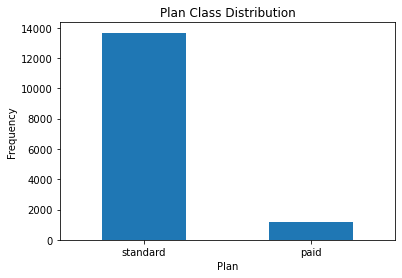

In [6]:
count_classes=pd.value_counts(df['plan'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.title('Plan Class Distribution')
plt.xticks(range(2),labels)
plt.xlabel('Plan')
plt.ylabel('Frequency')
plt.show()

In [7]:
Standard=df[df['plan']==0]
Paid=df[df['plan']==1]
print(Standard.shape,Paid.shape)

(13672, 45) (1149, 45)


In [8]:
os=SMOTE()
X_train,Y_train=os.fit_sample(x_train,y_train)
print('Original dataset shape is : ',x_train.shape, ' and ',y_train.shape)
print('Resampled dataset shape is: ',X_train.shape,' and ',Y_train.shape)

Original dataset shape is :  (11856, 10)  and  (11856,)
Resampled dataset shape is:  (21876, 10)  and  (21876,)


In [9]:
ssc=StandardScaler()
ssc.fit_transform(X_train)
ssc.transform(x_test)

array([[ 0.09079508,  0.40399996, -0.27945333, ..., -0.91724668,
        -0.73141026, -0.35893515],
       [-0.21503666, -0.59653247,  1.25735963, ...,  1.52231829,
         1.4207093 , -0.23081659],
       [-0.11236097,  0.82846826,  1.10121286, ...,  0.81504945,
         0.9293578 , -0.36351452],
       ...,
       [-0.22076669, -0.61775589, -0.64927463, ..., -1.23500514,
        -1.03604819, -0.19326281],
       [-0.18125979, -0.15690459,  0.17255048, ..., -0.35348167,
        -0.19092361, -0.34231029],
       [-0.02205777, -0.22967058,  1.80798245, ...,  1.69657293,
         1.77448238, -0.3373711 ]])

## Neural

In [10]:
 grid={'activation':['relu'],#'logistic','identity','tanh'],
      'learning_rate_init':[0.0001],
      'solver':['adam'],
      'batch_size':[128]
      #'momentum':[0.5]
       }

mlp=MLPClassifier()
gs=GridSearchCV(mlp,grid,cv=5,scoring='accuracy')
gs_result=gs.fit(X_train,Y_train)
print("Best: %f using %s" % (gs_result.best_score_, gs_result.best_params_))
mlp_pred=gs.predict(x_test)
print(accuracy_score(y_test,mlp_pred))
print(classification_report(y_test,mlp_pred))

Best: 0.702777 using {'activation': 'relu', 'batch_size': 128, 'learning_rate_init': 0.0001, 'solver': 'adam'}
0.6883642495784148
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      2734
           1       0.17      0.76      0.28       231

    accuracy                           0.69      2965
   macro avg       0.57      0.72      0.54      2965
weighted avg       0.91      0.69      0.76      2965



## Random Forest


In [11]:
var = VarianceThreshold()

rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rf.fit(X_train, Y_train)
rf.feature_importances_

for c, imp in sorted(zip(features, rf.feature_importances_), key=lambda pair: pair[1], reverse=True):
  print('{:20}: {}'.format(c, imp))

rf = RandomForestClassifier()

pipe1 = Pipeline([('selector', var),
                  ('model', rf)])

grid1 = {'selector__threshold': [0, 0.01, 0.5],
         'model__n_estimators': [101,102,103,104,105]}

clf = GridSearchCV(pipe1, grid1)
clf.fit(X_train, Y_train)

print(clf.best_params_, '\n')
print(classification_report(y_test, clf.predict(x_test)))

total_amount        : 0.23309106859203083
number_transactions : 0.19529277970910214
user_trans_periodicity: 0.11980384921937014
transaction_period  : 0.10852316039799045
age                 : 0.08347946419108242
user_active_time    : 0.0776669756739229
user_trans_time     : 0.07714435926852332
num_contacts        : 0.07317037299947221
brand               : 0.01638454420888935
user_settings_crypto_unlocked: 0.015443425739616065
{'model__n_estimators': 105, 'selector__threshold': 0.01} 

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2734
           1       0.29      0.49      0.36       231

    accuracy                           0.86      2965
   macro avg       0.62      0.69      0.64      2965
weighted avg       0.90      0.86      0.88      2965

